In [1]:
import pandas as pd
import seaborn as sn
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from typing import List

plt.style.use('ggplot')

In [25]:
names = pd.read_csv(
    filepath_or_buffer='dataset/names.csv',
    engine='pyarrow',
    dtype_backend='pyarrow' # Better memory efficiency and speed, 
                            # especially for strings and missing values. 
)

regions = pd.read_csv(
    filepath_or_buffer='dataset/regions.csv',
    engine='pyarrow',
    dtype_backend='pyarrow' # Better memory efficiency and speed, 
                            # especially for strings and missing values. 
)

dictionary = pd.read_csv(
    filepath_or_buffer='dataset/baby_names_db_data_dictionary.csv',
    engine='pyarrow',
    dtype_backend='pyarrow' # Better memory efficiency and speed, 
                            # especially for strings and missing values. 
)

In [26]:
# Converting column names to lower case for better readability
regions.columns = regions.columns.str.lower()
names.columns = names.columns.str.lower()

In [27]:
# It seems that I have to map state codes to conventional naming
regions.head()

state    region
0    AL     South
1    AK   Pacific
2    AZ  Mountain
3    AR     South
4    CA   Pacific

In [28]:
state_codes = {
    'AL': 'Alabama',        'AK': 'Alaska',        'AZ': 'Arizona',        'AR': 'Arkansas',
    'CA': 'California',     'CO': 'Colorado',      'CT': 'Connecticut',    'DE': 'Delaware',
    'FL': 'Florida',        'GA': 'Georgia',       'HI': 'Hawaii',         'ID': 'Idaho',
    'IL': 'Illinois',       'IN': 'Indiana',       'IA': 'Iowa',           'KS': 'Kansas',
    'KY': 'Kentucky',       'LA': 'Louisiana',     'ME': 'Maine',          'MD': 'Maryland',
    'MA': 'Massachusetts',  'MI': 'Michigan',      'MN': 'Minnesota',      'MS': 'Mississippi',
    'MO': 'Missouri',       'MT': 'Montana',       'NE': 'Nebraska',       'NV': 'Nevada',
    'NH': 'New Hampshire',  'NJ': 'New Jersey',    'NM': 'New Mexico',     'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota',  'OH': 'Ohio',           'OK': 'Oklahoma',
    'OR': 'Oregon',         'PA': 'Pennsylvania',  'RI': 'Rhode Island',   'SC': 'South Carolina',
    'SD': 'South Dakota',   'TN': 'Tennessee',     'TX': 'Texas',          'UT': 'Utah',
    'VT': 'Vermont',        'VA': 'Virginia',      'WA': 'Washington',     'WV': 'West Virginia',
    'WI': 'Wisconsin',      'WY': 'Wyoming'
}

regions['state_name'] = regions['state'].map(state_codes)

In [29]:
regions.head()

state    region  state_name
0    AL     South     Alabama
1    AK   Pacific      Alaska
2    AZ  Mountain     Arizona
3    AR     South    Arkansas
4    CA   Pacific  California

In [30]:
names.head()

state gender  year      name  births
0    AK      F  1980   Jessica     116
1    AK      F  1980  Jennifer     114
2    AK      F  1980     Sarah      82
3    AK      F  1980    Amanda      71
4    AK      F  1980   Melissa      65

Why am I using `right` join? `right` - keeps all records from the `names` table and adds matching region information from the `regions` table. Thus, all rows from the `names` table preserved `region` and `state_name` information added where state codes match.

In [31]:
df = pd.merge(regions, names, on='state', how='right')

In [32]:
df.head()

state   region state_name gender  year      name  births
0    AK  Pacific     Alaska      F  1980   Jessica     116
1    AK  Pacific     Alaska      F  1980  Jennifer     114
2    AK  Pacific     Alaska      F  1980     Sarah      82
3    AK  Pacific     Alaska      F  1980    Amanda      71
4    AK  Pacific     Alaska      F  1980   Melissa      65

In [33]:
# Brief info about resulting DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212361 entries, 0 to 2212360
Data columns (total 7 columns):
 #   Column      Dtype          
---  ------      -----          
 0   state       string[pyarrow]
 1   region      string[pyarrow]
 2   state_name  object         
 3   gender      string[pyarrow]
 4   year        int64[pyarrow] 
 5   name        string[pyarrow]
 6   births      int64[pyarrow] 
dtypes: int64[pyarrow](2), object(1), string[pyarrow](4)
memory usage: 118.3+ MB


In [34]:
# Detecting the number of NaN values per column. 
df.isnull().sum()

state             0
region        67800
state_name    85894
gender            0
year              0
name              0
births            0
dtype: int64

In [35]:
region_mapping = {
    'Pacific': 'Pacific',
    'South': 'South',
    'Mountain': 'Mountain',
    'New_England': 'New England',
    'Mid_Atlantic': 'Mid Atlantic',
    'Midwest': 'Midwest',
    'New England': 'New England',
    '<NA>': 'Unknown'  # or whatever you want to map NaN values to.
                       # I had choosen just "Unknown"
}

df['region'] = df['region'].map(region_mapping)

In [36]:
df.sample(1)

state   region state_name gender  year     name  births
832398    IL  Midwest   Illinois      F  1995  Abriana       8

In [37]:
gender_mapping = {
    'F': 'Female',
    'M': 'Male'
}

df['gender'] = df['gender'].map(gender_mapping)

In [38]:
df.sample(1)

state region state_name gender  year    name  births
2156705    VA  South   Virginia   Male  2004  Jaiden      33

## Analysis

In [39]:
df.head(3)

state   region state_name  gender  year      name  births
0    AK  Pacific     Alaska  Female  1980   Jessica     116
1    AK  Pacific     Alaska  Female  1980  Jennifer     114
2    AK  Pacific     Alaska  Female  1980     Sarah      82

### I. Regional Popularity Analysis

In [14]:
df['region'].unique()

array(['Pacific', 'South', 'Mountain', 'New England', 'Mid Atlantic',
       'Midwest', nan], dtype=object)

In [15]:
region_popularity = df.groupby('region') \
                      .agg(names=('name', 'count')) \
                      .sort_values(by='names', ascending=True)
region_popularity

names
region              
New England   120809
Mountain      221741
Mid Atlantic  267785
Pacific       294260
Midwest       441464
South         798502

In [16]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=region_popularity['names'].min(),
    vmax=region_popularity['names'].max()
)
cmap = plt.cm.viridis
colors = cmap(norm(region_popularity['names']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=region_popularity.index,
    width=region_popularity['names'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Total Births by Region',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Total Births',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='Region',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Total Births',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

### II. Gender Distribution by Region

In [41]:
gender_distribution = df.groupby(['region', 'gender']) \
                        .agg({'name': 'count'})

gender_distribution.head()

name
region       gender        
Mid Atlantic Female  151879
             Male    115906
Midwest      Female  248632
             Male    192832
Mountain     Female  121880

In [42]:
gender_distribution = gender_distribution.reset_index()
gender_distribution.head()

region  gender    name
0  Mid Atlantic  Female  151879
1  Mid Atlantic    Male  115906
2       Midwest  Female  248632
3       Midwest    Male  192832
4      Mountain  Female  121880

In [43]:
regions = gender_distribution['region'].unique().tolist()

female_values = gender_distribution[
    gender_distribution['gender'] == 'Female'
    ]['name'].to_list()

male_values = gender_distribution[
    gender_distribution['gender'] == 'Male'
    ]['name'].to_list()


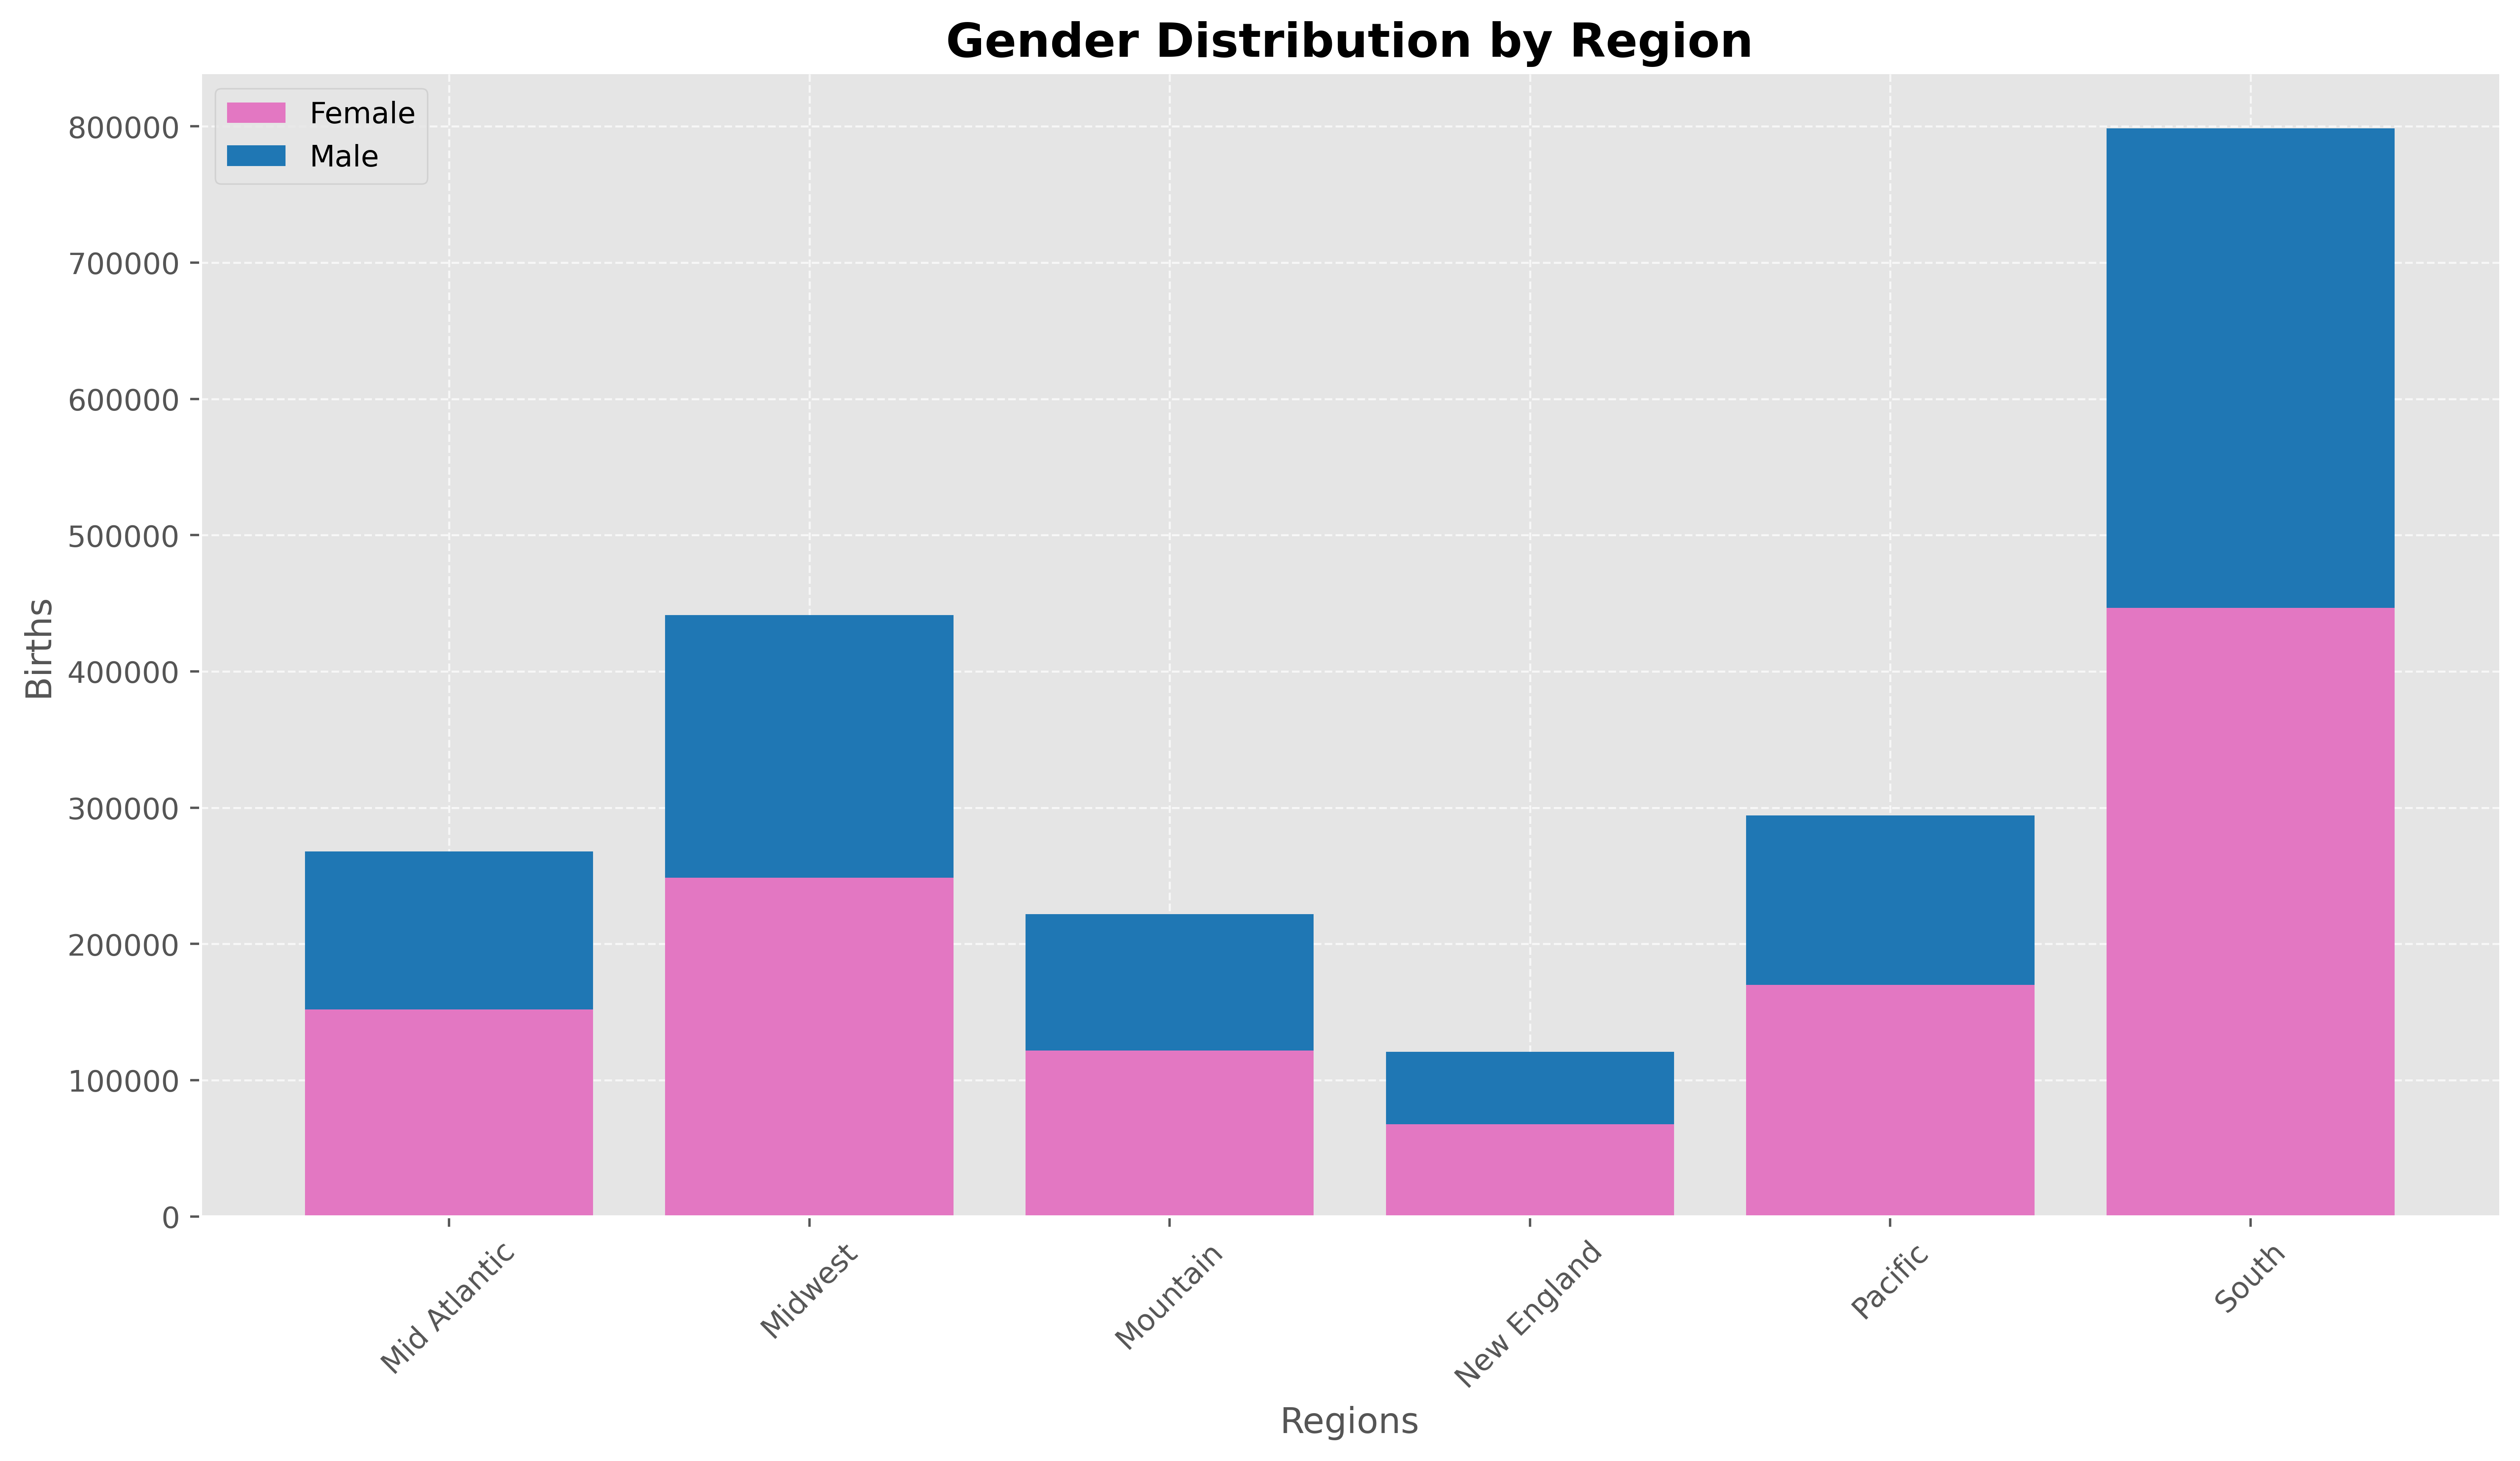

In [44]:
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1, 
    dpi=500, 
    figsize=(12, 7))

# Color Palette
colors = {
    'male_color': '#1f77b4',    # Blue
    'female_color': '#e377c2'   # Pink
}

gender_index = 0
for region in regions:
    ax.bar(
        region, 
        female_values[gender_index], 
        color=colors['female_color'],
        label='Female' if gender_index == 0 else ""
    )

    ax.bar(
        region, 
        male_values[gender_index], 
        color=colors['male_color'],
        label='Male' if gender_index == 0 else "",
        bottom=female_values[gender_index]
    )

    gender_index += 1

ax.set_title("Gender Distribution by Region", fontsize=16, fontweight='bold')
ax.set_ylabel("Births", fontsize=12)
ax.set_xlabel("Regions", fontsize=12)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=10)

ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

ax.legend(title="Regions", fontsize=10, title_fontsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.legend()
plt.show()

### III. Top Names by Region

In [45]:
top_names = df.groupby(['region', 'name']) \
              .agg(births=('name', 'count')) \
              .sort_values(['region', 'births'], ascending=[True, False]) \
              .reset_index()

In [46]:
regions = top_names['region'].unique()

regions_and_top_names = pd.DataFrame()

for region in regions:
    temp = top_names[top_names['region'] == region].iloc[: 5]
    regions_and_top_names = pd.concat([regions_and_top_names, temp], ignore_index=True)

In [48]:
regions_and_top_names.head(5)

region    name  births
0  Mid Atlantic  Jordan     234
1  Mid Atlantic  Alexis     232
2  Mid Atlantic   Angel     225
3  Mid Atlantic    Ryan     220
4  Mid Atlantic  Taylor     219

### IV. Yearly Trend Analysis

In [49]:
yearly_names = df.groupby('year') \
                 .agg(births=('name', 'count')) \
                 .reset_index()

yearly_names.sample(5)

year  births
18  1998   76040
11  1991   69751
12  1992   70884
8   1988   64216
16  1996   72337

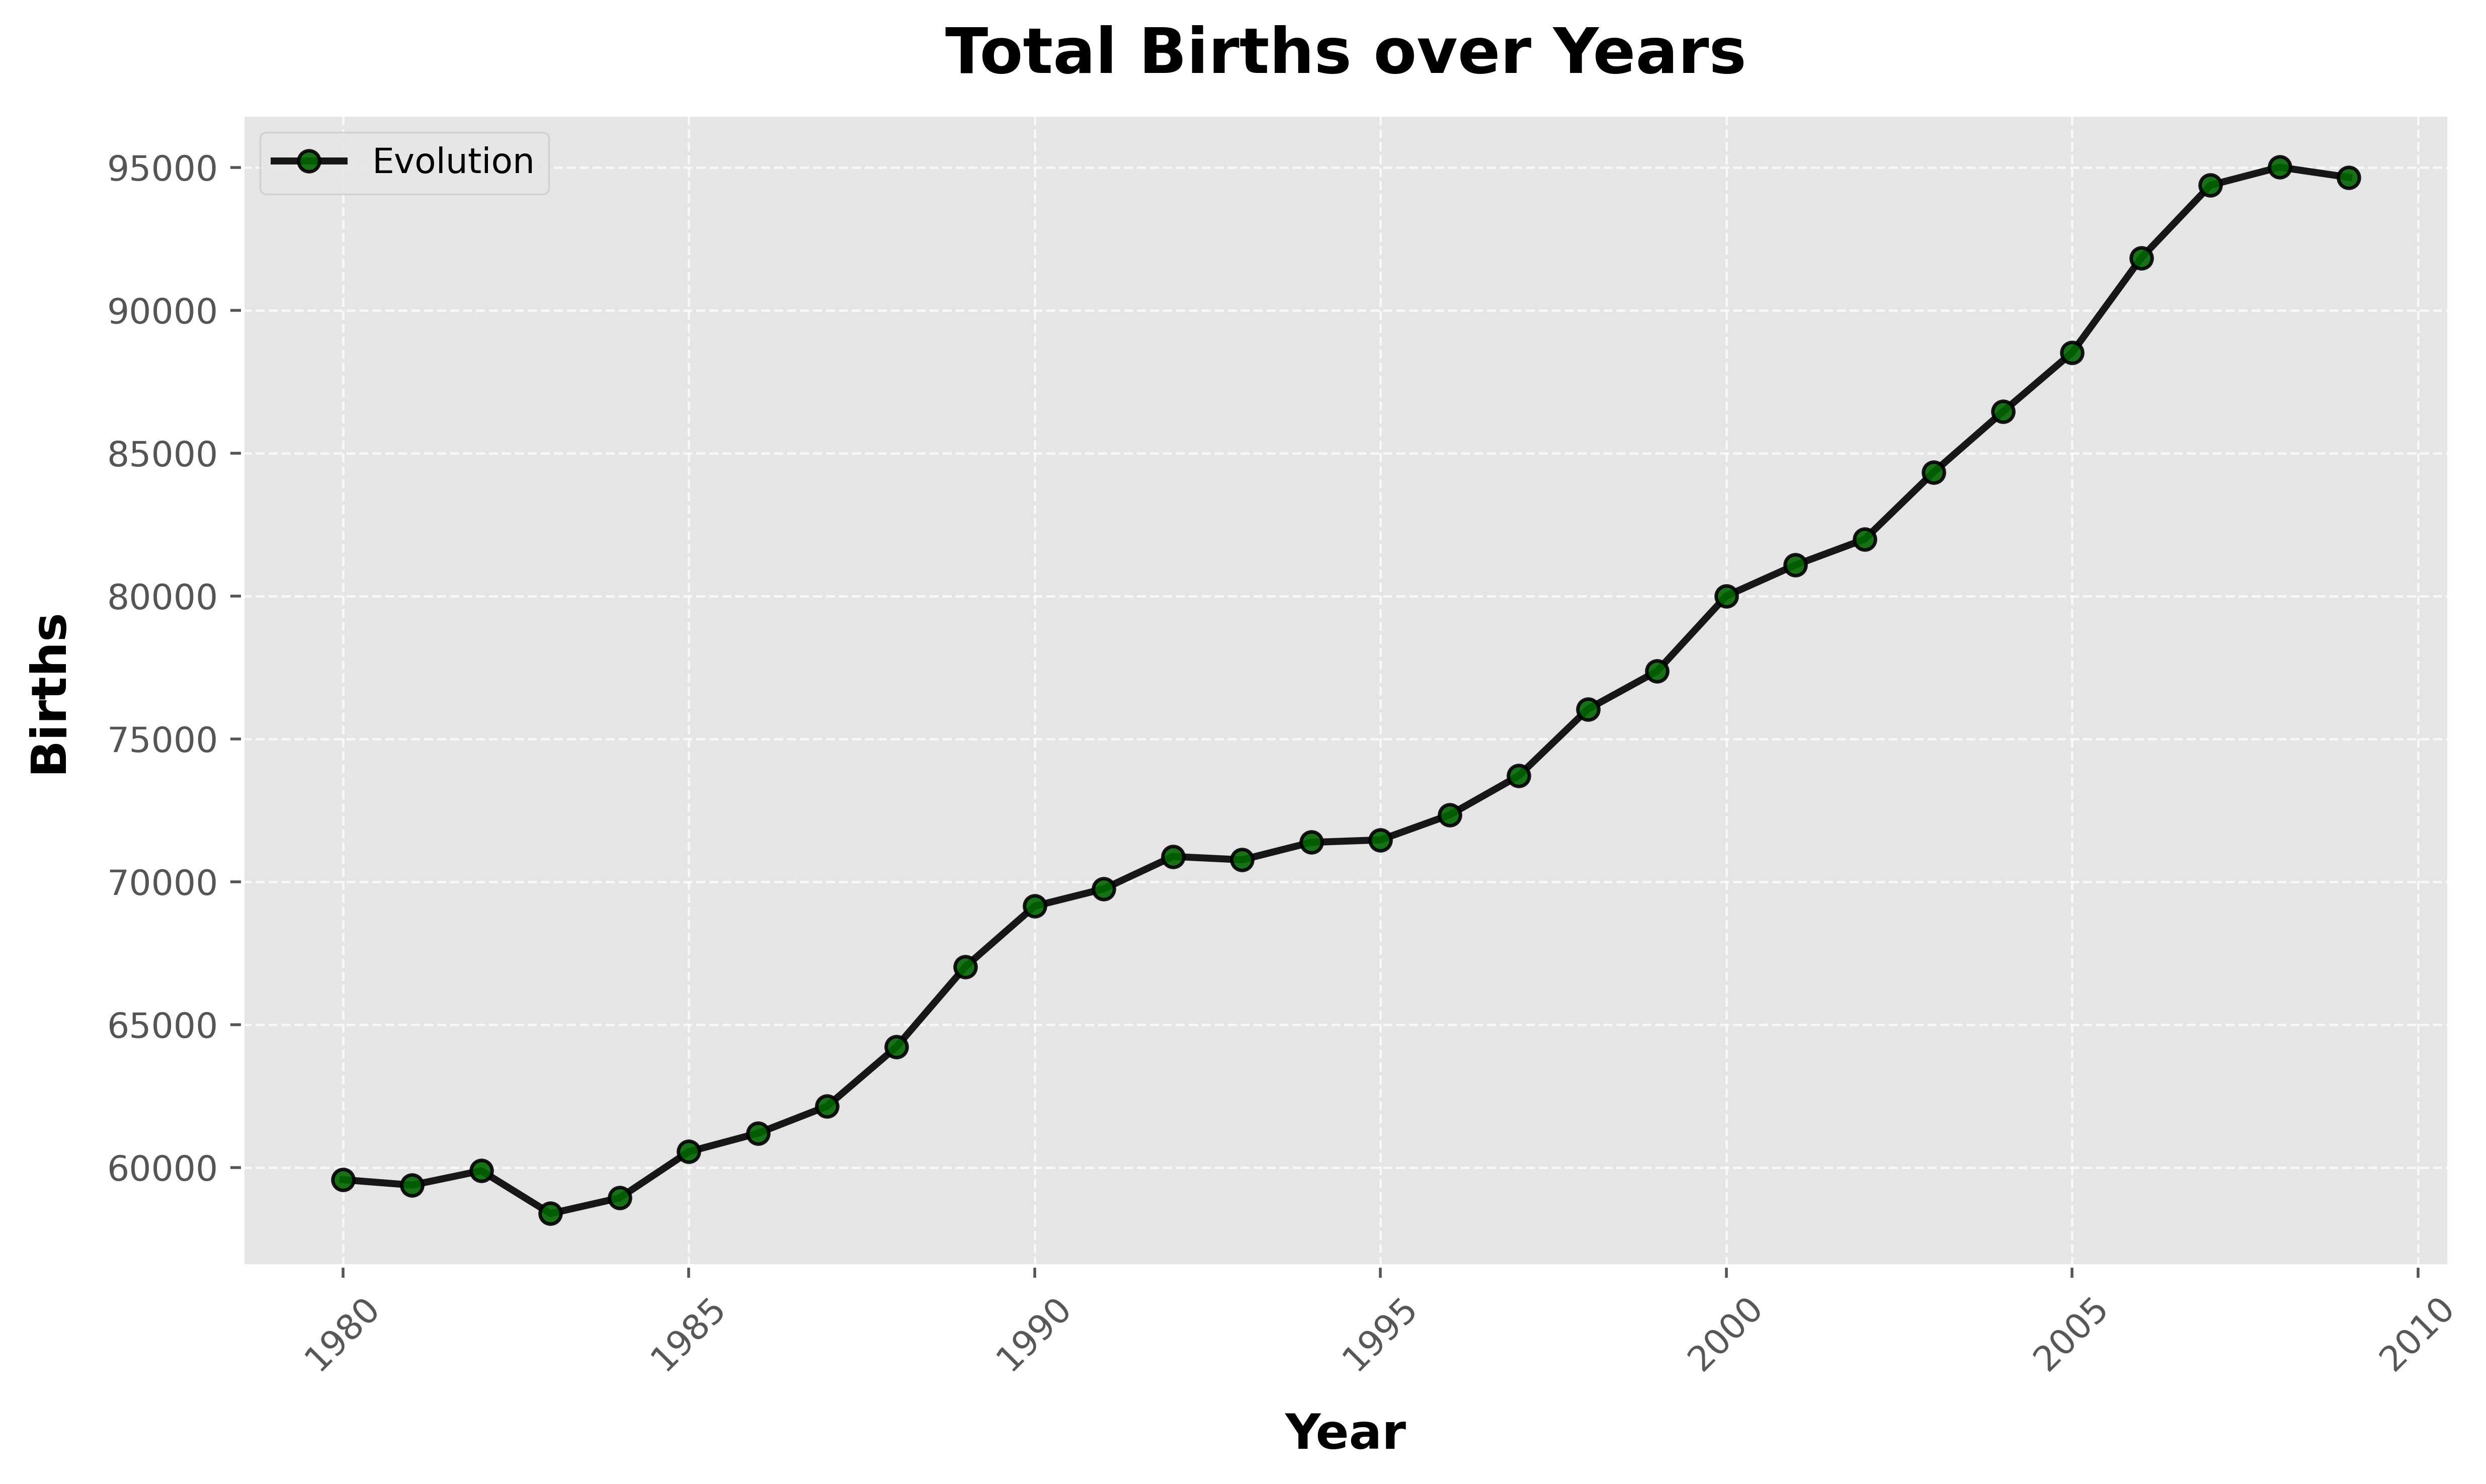

In [50]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
    dpi=500
)

ax.plot(
    yearly_names['year'],
    yearly_names['births'],
    color='black',
    linestyle='-',
    linewidth=2,
    marker='o',
    markersize=6,
    markerfacecolor='darkgreen',
    markeredgecolor='black',
    alpha=0.9,
    label='Evolution'
)

ax.set_title(
    "Total Births over Years",
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=12
)

ax.set_xlabel(
    "Year",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    "Births",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10,
    loc='center'
)

# formatting x-axis ticks to see dates. 
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Configuring grid
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

plt.xticks(rotation=45)

ax.legend(
    fontsize=10,
    loc='upper left',
    frameon=True
)

plt.tight_layout()
plt.show()


In [114]:
df.head()

state   region state_name  gender  year      name  births
0    AK  Pacific     Alaska  Female  1980   Jessica     116
1    AK  Pacific     Alaska  Female  1980  Jennifer     114
2    AK  Pacific     Alaska  Female  1980     Sarah      82
3    AK  Pacific     Alaska  Female  1980    Amanda      71
4    AK  Pacific     Alaska  Female  1980   Melissa      65

### V. Top Names and Trend

In [51]:
names_trend = df.groupby(['year', 'name']) \
                .agg(births=('name', 'count')) \
                .reset_index()

In [53]:
names_trend.head()

year     name  births
0  1980  Aaliyah       3
1  1980    Aaron      63
2  1980    Aarti       1
3  1980    Abbey      21
4  1980    Abbie      20

In [54]:
def build_lineplot(names: List[str]):
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 6),
        dpi=500
    )
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, name in enumerate(names):
        if i >= 5:
            print(f"Warning: Only showing first 5 names. Skipping {name}")
            break
            
        ax.plot(
            names_trend['year'].unique(),
            names_trend[names_trend['name'] == name]['births'].to_list(),
            color=colors[i],
            linestyle='-',
            linewidth=2.5,
            marker='o',
            markersize=6,
            markerfacecolor=colors[i],
            markeredgecolor='black',
            alpha=0.7,
            label=name
        )

    ax.set_title(
        "Total Births over Years",
        fontsize=18,
        fontweight='bold',
        color='black',
        loc='center',
        pad=12
    )

    ax.set_xlabel(
        "Year",
        fontsize=14,
        fontweight='bold',
        color='black',
        labelpad=10
    )

    ax.set_ylabel(
        "Births",
        fontsize=14,
        fontweight='bold',
        color='black',
        labelpad=10
    )

    # Formatting x-axis ticks to show years
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xticks(rotation=45)

    ax.legend(
        fontsize=10,
        loc='best',
        frameon=True,
        fancybox=True,
        shadow=True
    )

    plt.tight_layout()
    plt.show()

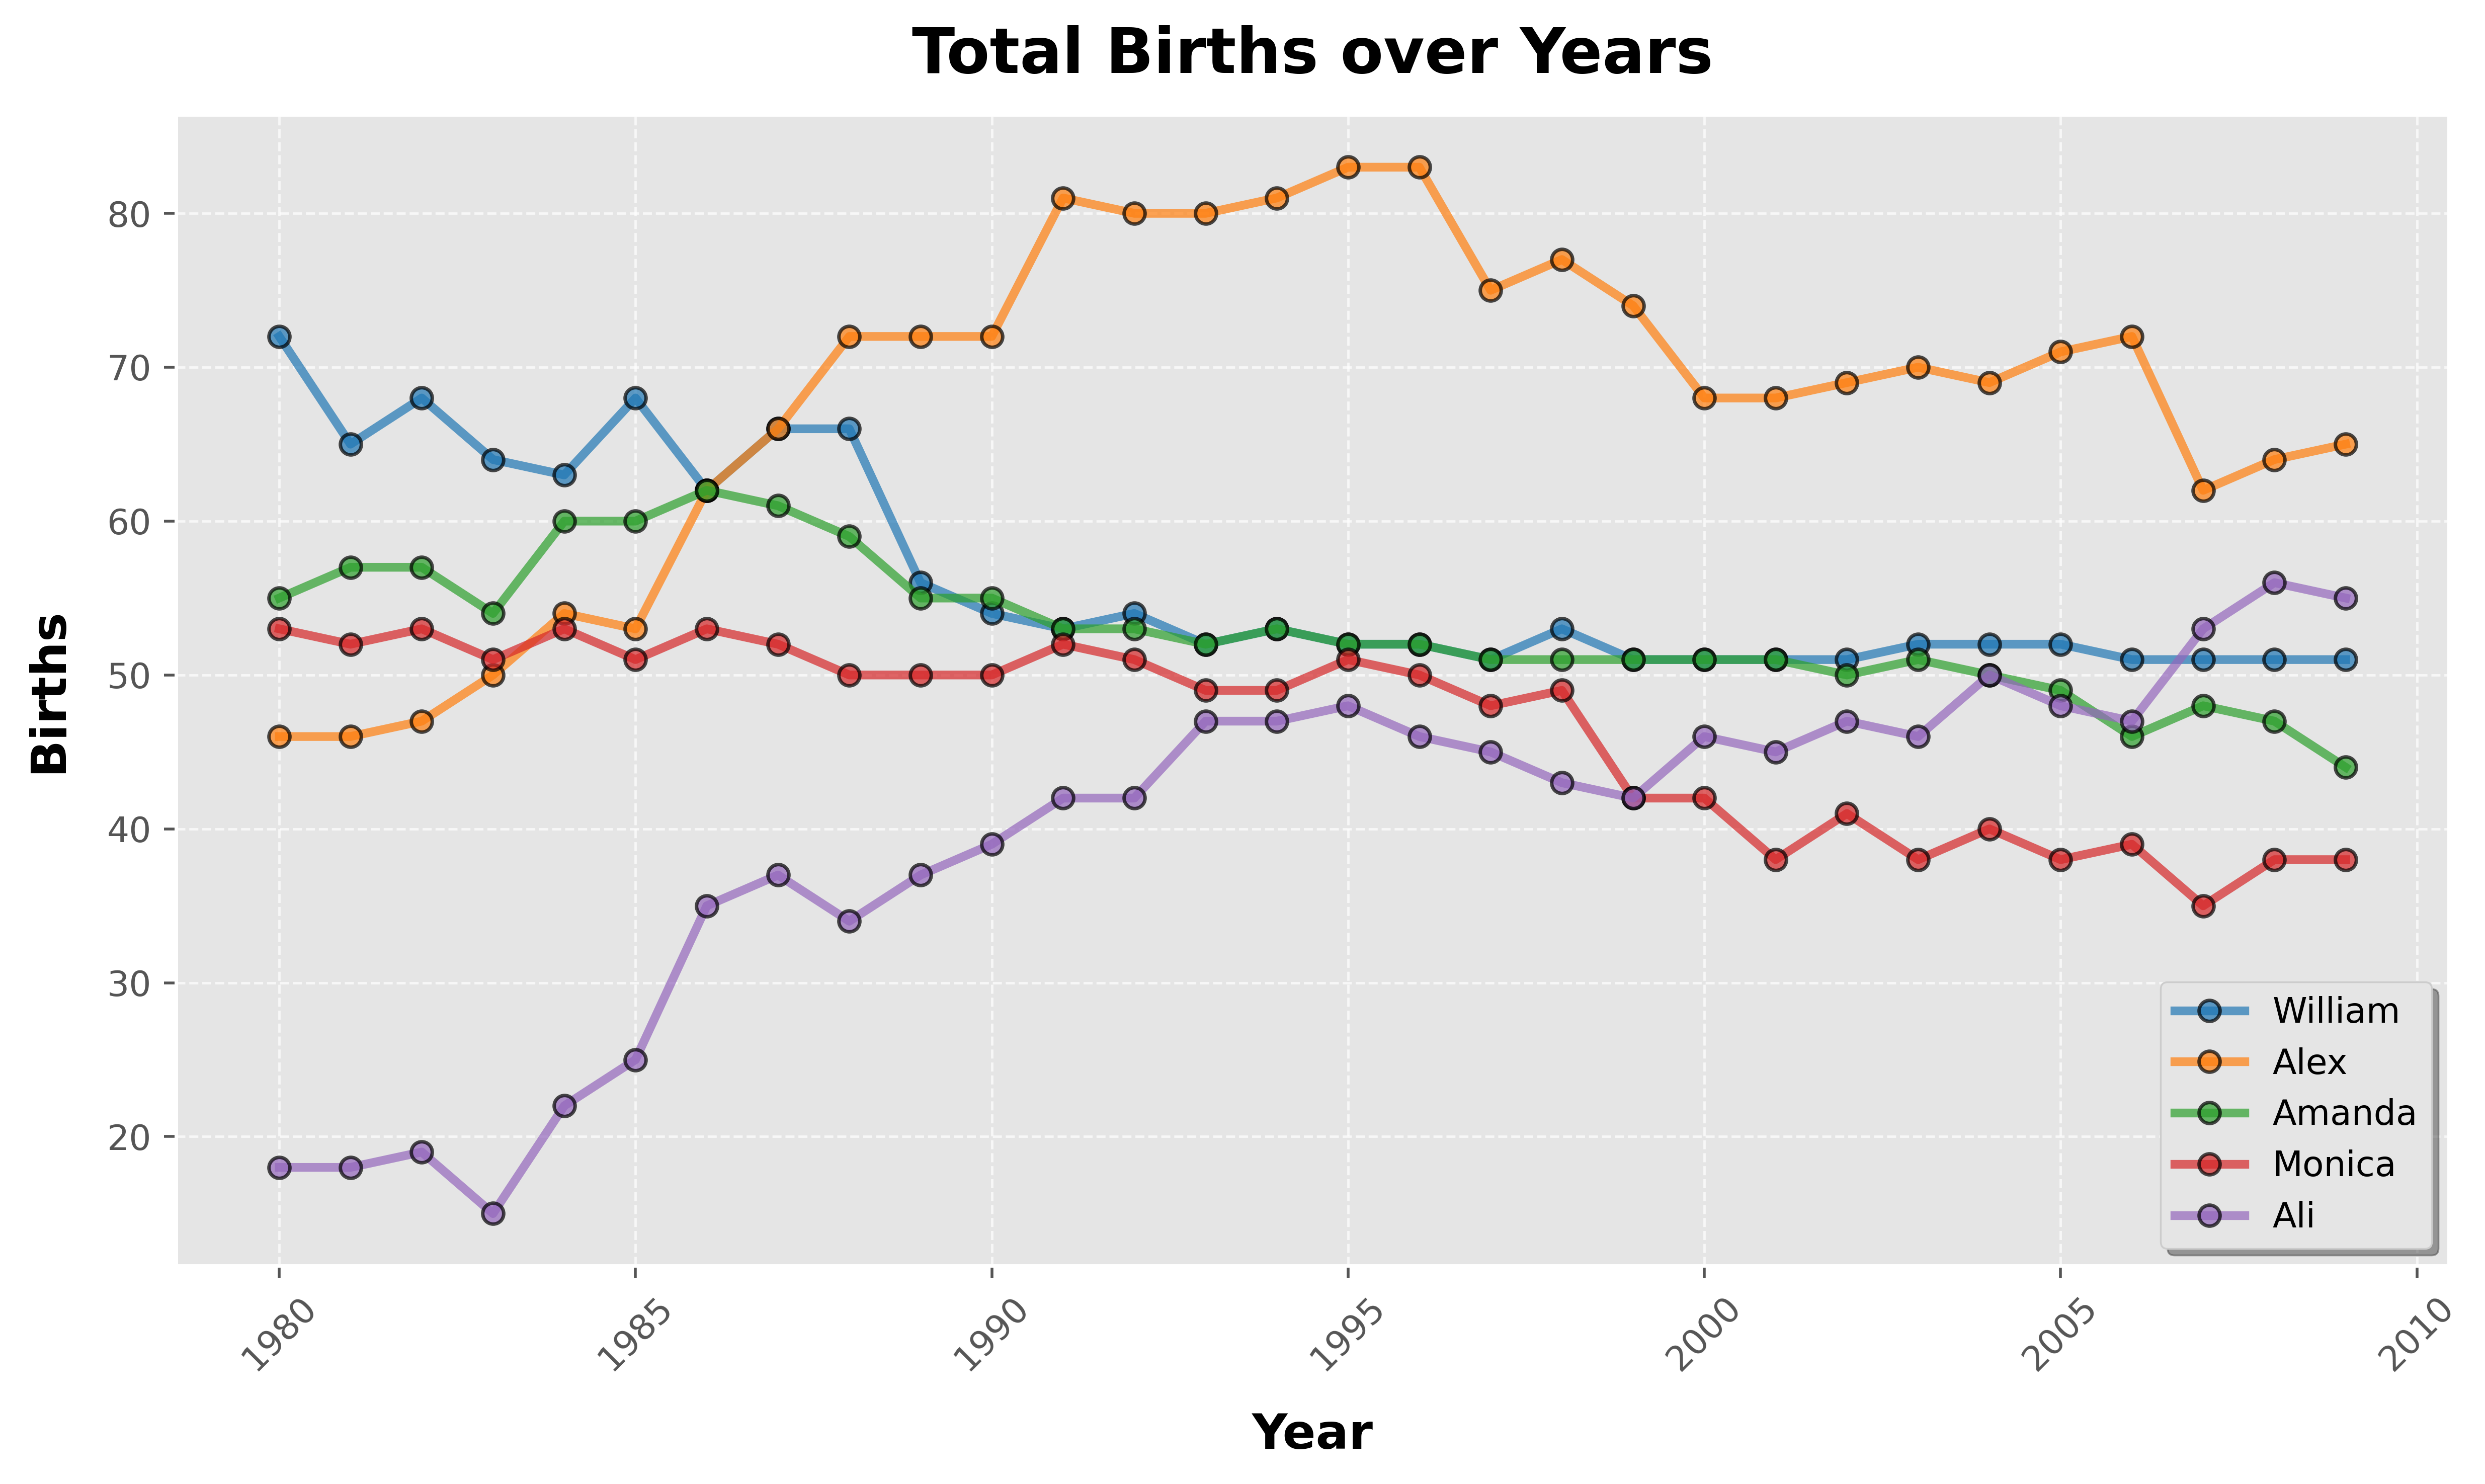

In [55]:
names = ['William', 'Alex', 'Amanda', 'Monica', 'Ali']
build_lineplot(names=names)

### VI. Gender Rivalry

In [56]:
gender_rivalry = df.groupby(['year', 'gender']) \
                   .agg(births=('name', 'count')) \
                   .reset_index()

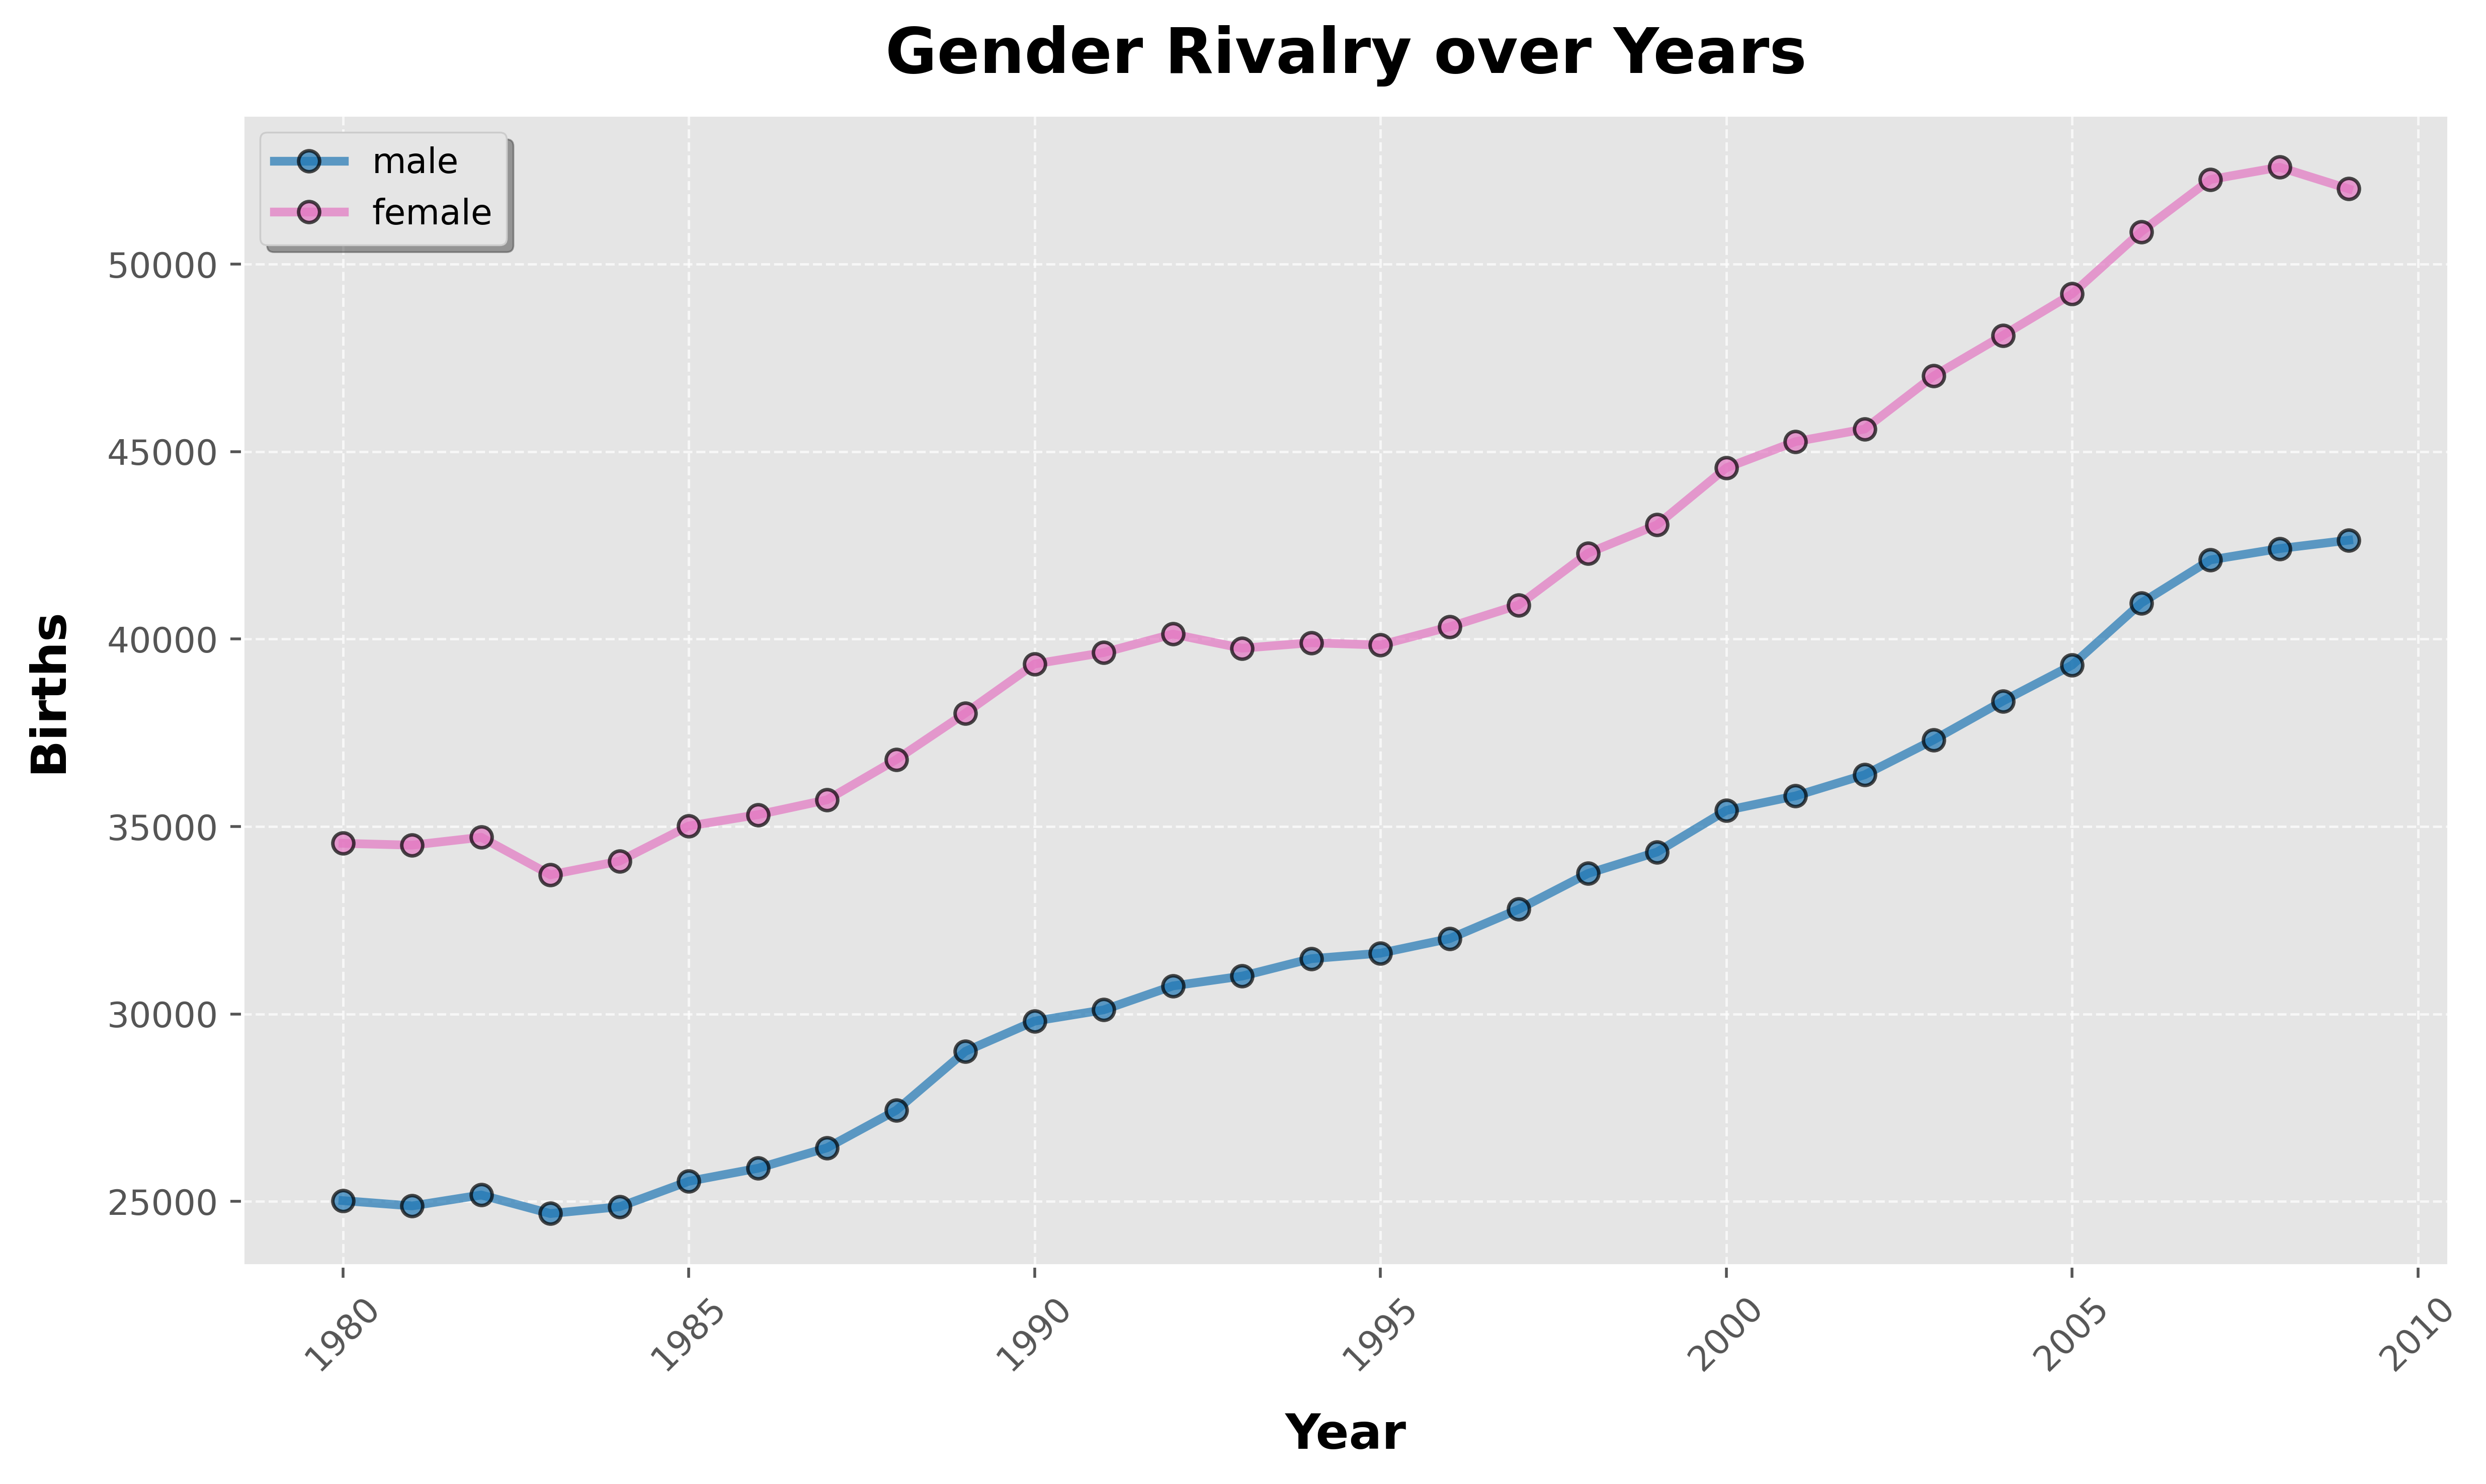

In [57]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
    dpi=500
)

# Color Palette
colors = {
    'male_color': '#1f77b4',    # Blue
    'female_color': '#e377c2'   # Pink
}

ax.plot(
    names_trend['year'].unique(),
    gender_rivalry[gender_rivalry['gender'] == 'Male']['births'].to_list(),
    color=colors['male_color'],
    linestyle='-',
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor=colors['male_color'],
    markeredgecolor='black',
    alpha=0.7,
    label='male'
)

ax.plot(
    names_trend['year'].unique(),
    gender_rivalry[gender_rivalry['gender'] == 'Female']['births'].to_list(),
    color=colors['female_color'],
    linestyle='-',
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor=colors['female_color'],
    markeredgecolor='black',
    alpha=0.7,
    label='female'
)

ax.set_title(
    "Gender Rivalry over Years",
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=12
)

ax.set_xlabel(
    "Year",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10
)

ax.set_ylabel(
    "Births",
    fontsize=14,
    fontweight='bold',
    color='black',
    labelpad=10
)

# Formatting x-axis ticks to show years
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

plt.xticks(rotation=45)

ax.legend(
    fontsize=10,
    loc='best',
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.tight_layout()
plt.show()

### VII. Births per States over time

In [58]:
births_per_states = df.groupby(['year', 'state_name']) \
                      .agg(births=('name', 'count')) \
                      .reset_index()

In [59]:
def build_lineplot_states(states: List[str]):
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 6),
        dpi=700
    )
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, state in enumerate(states):
        if i >= 5:
            print(f"Warning: Only showing first 5 states. Skipping {state}")
            break
            
        ax.plot(
            births_per_states['year'].unique(),
            births_per_states[
                births_per_states['state_name'] == state]['births'].to_list(),
            color=colors[i],
            linestyle='-',
            linewidth=2.5,
            marker='o',
            markersize=6,
            markerfacecolor=colors[i],
            markeredgecolor='black',
            alpha=0.7,
            label=state
        )

    ax.set_title(
        "Total Births over Years",
        fontsize=18,
        fontweight='bold',
        color='black',
        loc='center',
        pad=12
    )

    ax.set_xlabel(
        "Year",
        fontsize=14,
        fontweight='bold',
        color='black',
        labelpad=10
    )

    ax.set_ylabel(
        "Births",
        fontsize=14,
        fontweight='bold',
        color='black',
        labelpad=10
    )

    # Formatting x-axis ticks to show years
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xticks(rotation=45)

    ax.legend(
        fontsize=10,
        loc='best',
        frameon=True,
        fancybox=True,
        shadow=True
    )

    plt.tight_layout()
    plt.show()

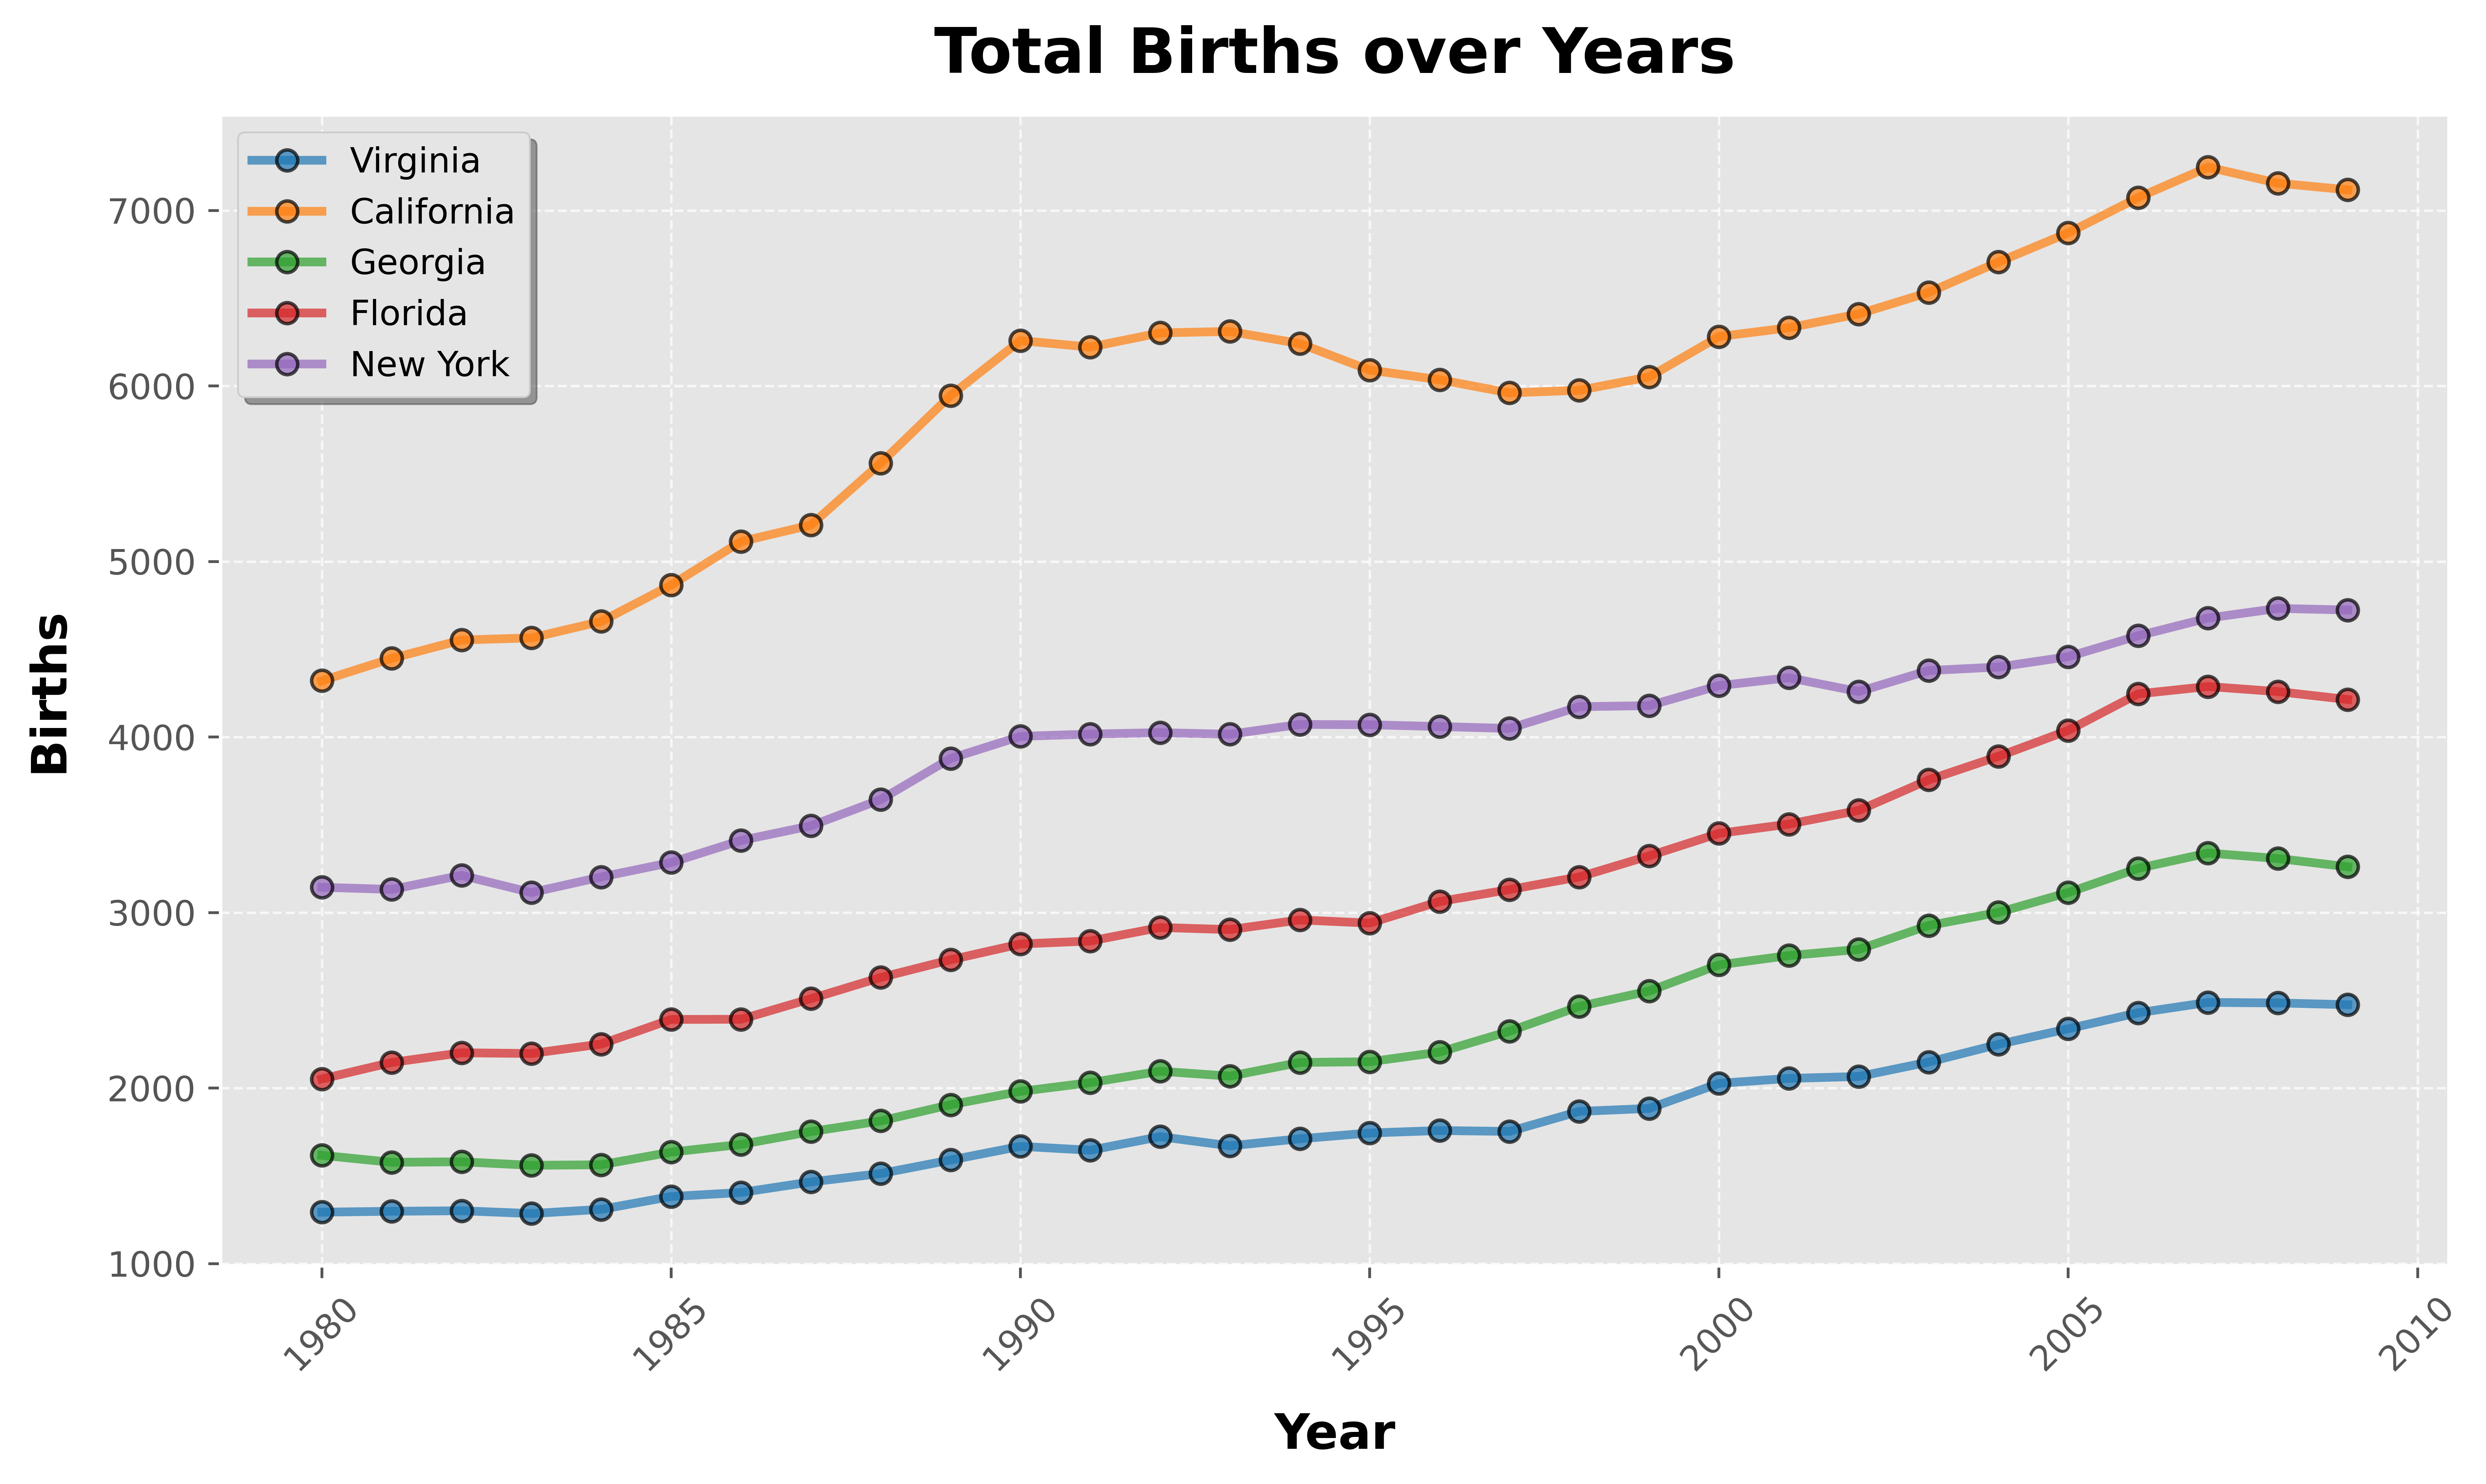

In [60]:
states = ['Virginia', 'California', 'Georgia', 'Florida', 'New York']
build_lineplot_states(states=states)

### VII. Distinct Names per State

In [61]:
distinct_names = df.groupby('state_name') \
                   .agg(distinct_names=('name', 'unique'))

In [62]:
# Counting the number of distinct names for each state
distinct_names['number_of_distinct_names'] = distinct_names['distinct_names'].apply(len)

In [63]:
# Sorting based on the number of distinct names
distinct_names = distinct_names.sort_values(
    by='number_of_distinct_names', ascending=False)

In [64]:
# Picking random 20 states for comparison in horizontal bar chart
distinct_names = distinct_names.sample(20)
distinct_names = distinct_names.sort_values(
    by='number_of_distinct_names', ascending=True
)

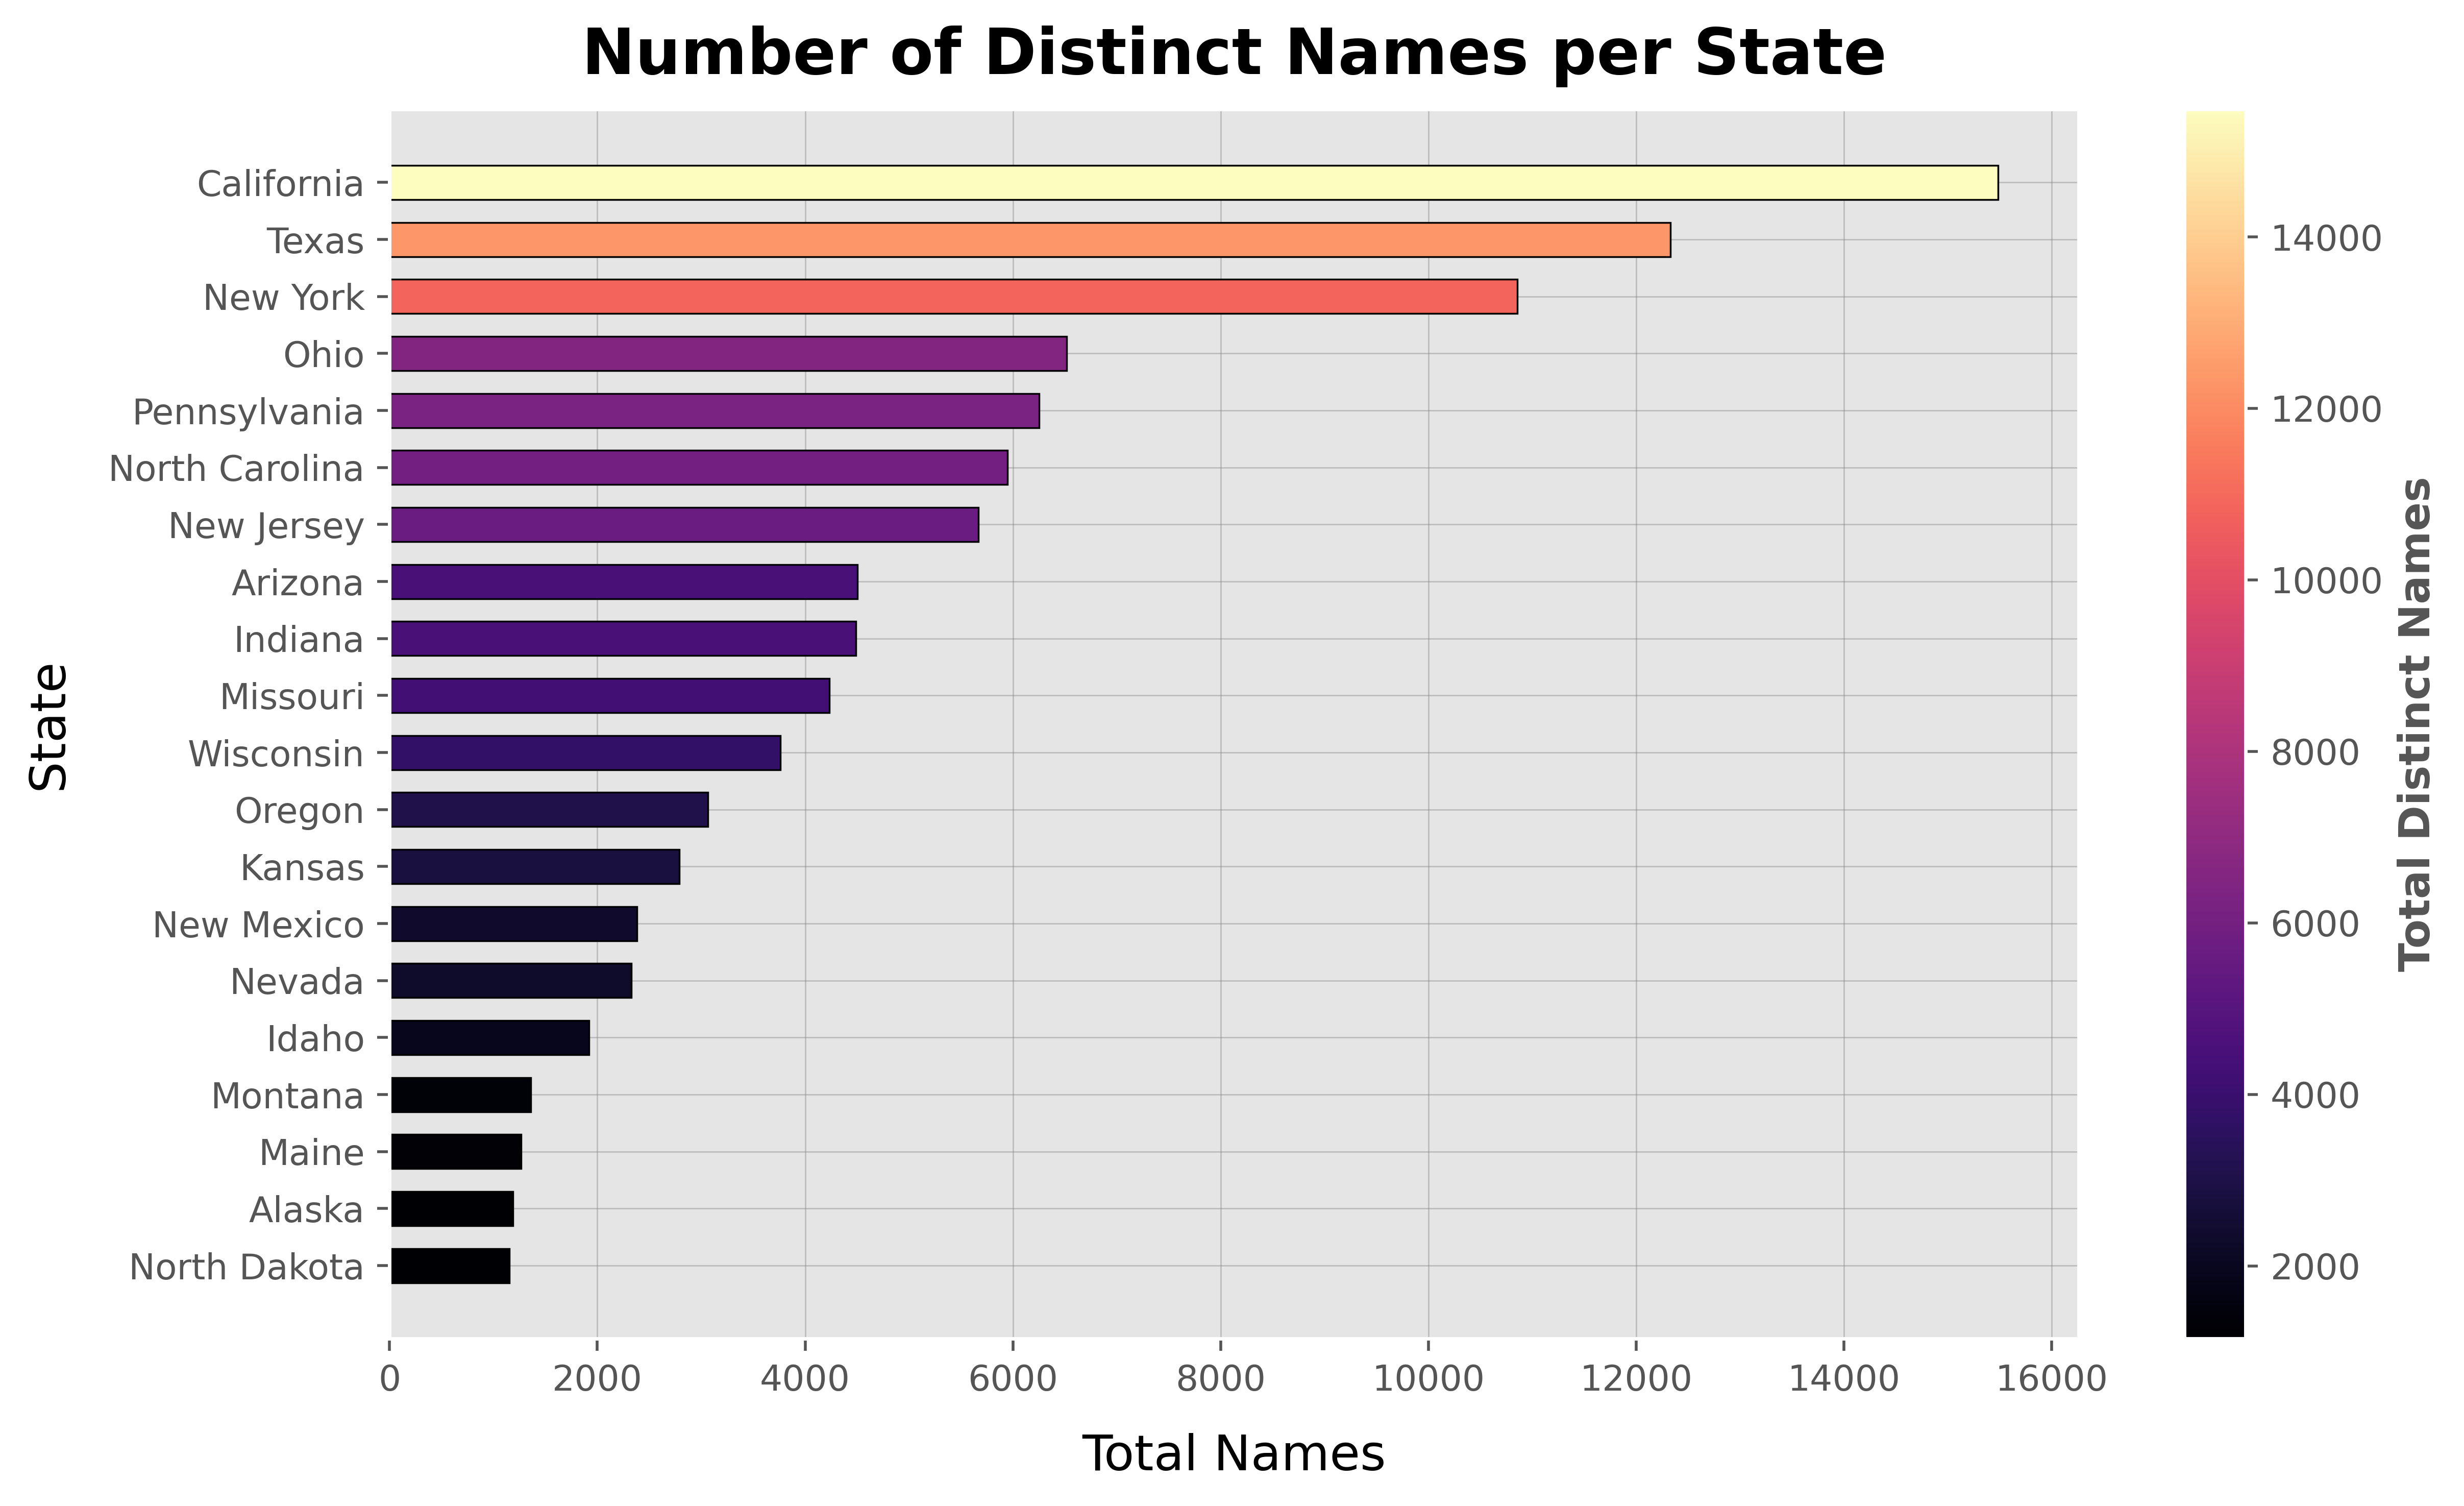

In [65]:
# Normalizing the data for colormap (0 to 1)
norm = mcolors.Normalize(
    vmin=distinct_names['number_of_distinct_names'].min(),
    vmax=distinct_names['number_of_distinct_names'].max()
)
cmap = plt.cm.magma
colors = cmap(norm(distinct_names['number_of_distinct_names']))

fig, ax = plt.subplots(
    figsize=(10, 6),
    dpi=500,
)

ax.barh(
    y=distinct_names.index,
    width=distinct_names['number_of_distinct_names'],
    height=0.6,
    color=colors,
    edgecolor='black'
)

ax.set_title(
    label='Number of Distinct Names per State',
    fontsize=18,
    fontweight='bold',
    color='black',
    loc='center',
    pad=10
)

ax.set_xlabel(
    xlabel='Total Names',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.set_ylabel(
    ylabel='State',
    fontsize=14,
    color='black',
    labelpad=10,
    loc='center'
)

ax.grid(
    visible=True,
    which='major',
    axis='both',
    color='gray',
    linestyle='-',
    linewidth=0.4,
    alpha=0.4
)

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(
    label='Total Distinct Names',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()